In [2]:
import numpy as np
import cv2
from sklearn.cluster import DBSCAN
import os
from matplotlib import pyplot as plt

In [3]:
def preProcessing(img):

    # Reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = img.reshape((-1, 3))
    # Convert to float
    pixel_values = np.float32(pixel_values)

    # cv2.imshow('Image', img)
    # cv2.waitKey(0)

    return img, pixel_values

def count_colors(img, eps, min_samples):
    # Resize the image to speed up processing, if needed
    resized_img = cv2.resize(img, (100, 100))  # Adjust the size as necessary

    # Convert the image to the LAB color space
    lab_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2LAB)

    # Get the values of the L, A, and B channels
    l_values = lab_img[:, :, 0].flatten() # flatten() returns a copy of the array collapsed into one dimension
    a_values = lab_img[:, :, 1].flatten()
    b_values = lab_img[:, :, 2].flatten()

    # Combine the channel values into a single array
    lab_values = np.column_stack((l_values, a_values, b_values))

    # Run the DBSCAN algorithm to cluster similar color channel values
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(lab_values)

    # Get the labels of the found clusters
    labels = dbscan.labels_

    # Count the number of distinct colors considering small variations as the same color
    num_colors = len(np.unique(labels))

    return num_colors
    

def segment(img):
    new_img, pixel_values = preProcessing(img)
     
    # Define stopping criteria
    # cv.TERM_CRITERIA_EPS - interrompe a iteração do algoritmo se a precisão especificada, epsilon , for atingida.
    # cv.TERM_CRITERIA_MAX_ITER - para o algoritmo após o número especificado de iterações, max_iter .
    # max_iter - Um inteiro especificando o número máximo de iterações.
    # epsilon - Precisão necessária
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 0.05)
    k = count_colors(new_img, 15, 30)
    print(k)

    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to 8-bit values
    centers = np.uint8(centers)

    # Flatten the labels array
    labels = labels.flatten()

    # Convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]

    # Reshape back to the original image dimensions
    segmented_image = segmented_image.reshape(img.shape)

    # Convert the labels to a numpy array with the shape of the original image
    labels = labels.reshape(img.shape[:2])

    # Create the segmented image for each cluster
    segmented_imgs = []
    for i in range(k):
        segmented_imgs.append(np.zeros_like(img))
        segmented_imgs[i][labels == i] = new_img[labels == i]

    return segmented_imgs

def find_bars(img, segmented_imgs):
    bars_found = []

    colors = [(np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)) for _ in range(len(segmented_imgs))] 

    for idx, segmented_img in enumerate(segmented_imgs):
        # Convert the segmented image to grayscale

        # cv2.imshow('Image', segmented_img)
        # cv2.waitKey(0)

        kernel = np.ones((3,3),np.uint8)

        # Applying dilation operation
        dilated_img = cv2.dilate(segmented_img, kernel, iterations=1)

        # Applying erosion operation
        eroded_img = cv2.erode(dilated_img, kernel, iterations=1)
        
        # cv2.imshow('Image', eroded_img)
        # cv2.waitKey(0)

        gray_segmented_img = cv2.cvtColor(eroded_img, cv2.COLOR_BGR2GRAY)
    
        # Applying threshold to binarize the segmented image
        _, binary_segmented_img = cv2.threshold(gray_segmented_img, 0, 255, cv2.THRESH_BINARY)

        # Show the binarized image
        # cv2.imshow('Image', binary_segmented_img)
        # cv2.waitKey(0)

        output = cv2.connectedComponentsWithStats(binary_segmented_img, 4, cv2.CV_32S)
        (numLabels, labels, stats, centroids) = output
        for i in range(1, numLabels):
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            area = stats[i, cv2.CC_STAT_AREA]

            roi = img[y:y+h, x:x+w]
            _, std_dev = cv2.meanStdDev(roi) # standard deviation
            if std_dev[0][0] < 25 and area > 75 and w > 1 and h > 1:
                cv2.rectangle(img, (x, y), (x+w, y+h), colors[idx], 2)
    return img

test_synthetic_simple_115.jpg


5


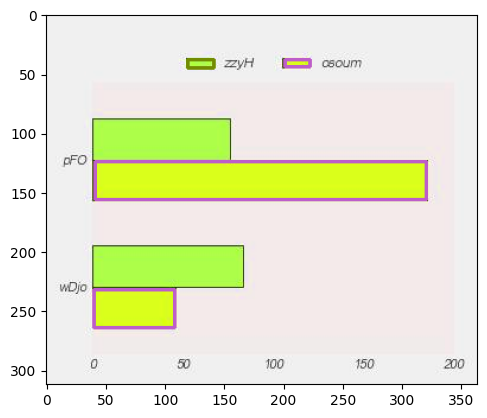

In [4]:
directory = "dataset/test_synthetic_simple/plots" 

cont = 0
for filename in os.listdir(directory):
    if cont == 1:
        break

    if filename.endswith(".jpg") or filename.endswith(".png"): 
        print(filename)
        img = cv2.imread(directory+ "/" + filename)

        segmented_imgs = segment(img)
        img = find_bars(img, segmented_imgs)

        plt.imshow(img)
        plt.show()

        cont += 1